<a href="https://colab.research.google.com/github/Darwin-Tandi/Hybrid-Fuzzy-RL/blob/main/uas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORT DATASET AND LIBRARY

In [ ]:
!pip install -q stable-baselines3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import seaborn as sns
import gymnasium as gym
import random
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from gymnasium import spaces
# https://drive.google.com/file/d/1po2vUDWZ-HqlYaTLtZ3u13B6-diKWU00/view?usp=sharing
file_id = '1po2vUDWZ-HqlYaTLtZ3u13B6-diKWU00'
output_file = 'dataset.csv'

url = f'https://drive.google.com/uc?export=download&id={file_id}'
!wget --no-check-certificate "{url}" -O {output_file}

df = pd.read_csv(output_file, encoding = 'latin-1')
df.head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.6 MB/s eta 0:00:00
--2025-05-07 14:03:49--  https://drive.google.com/uc?export=download&id=1po2vUDWZ-HqlYaTLtZ3u13B6-diKWU00
Resolving drive.g

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08.26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08.26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08.26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08.26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08.26,3.39,17850.0,United Kingdom


#PREPROCESSING

In [ ]:
#clear description
df = df.drop(columns=['Description'])
#invoice adjustment

df = df[~df['InvoiceNo'].str.startswith(('A', 'C'))]
# Remove rows with Quantity <= 0 (negative or zero = returns, errors)
df = df[df['Quantity'] > 0]

# Convert UnitPrice to numeric (if string), then remove where UnitPrice <= 0
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce')
df = df[df['UnitPrice'] > 0]

# Drop rows with missing CustomerID (likely guests or system errors)
df = df.dropna(subset=['CustomerID'])

# 6. Optional: Drop rows with missing/unknown countries (usually small)
df = df[df['Country'].notnull()]

# 7. Reset index for cleanliness
df = df.reset_index(drop=True)

# Preview cleaned data
print(df.shape)
df.head()

(397859, 7)


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,6,01/12/2010 08.26,2.55,17850.0,United Kingdom
1,536365,71053,6,01/12/2010 08.26,3.39,17850.0,United Kingdom
2,536365,84406B,8,01/12/2010 08.26,2.75,17850.0,United Kingdom
3,536365,84029G,6,01/12/2010 08.26,3.39,17850.0,United Kingdom
4,536365,84029E,6,01/12/2010 08.26,3.39,17850.0,United Kingdom


#PLOTTING FUZZY USE WEIGHTED

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 16.3 MB/s eta 0:00:00
Fuzzy Partition Coefficient (FPC): 0.6423
Cluster Distribution:
 Cluster
1    1803
0    1543
2     991
Name: count, dtype: int64


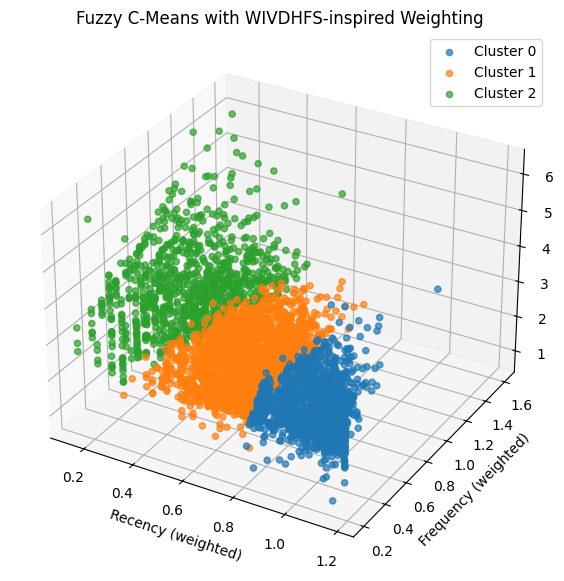

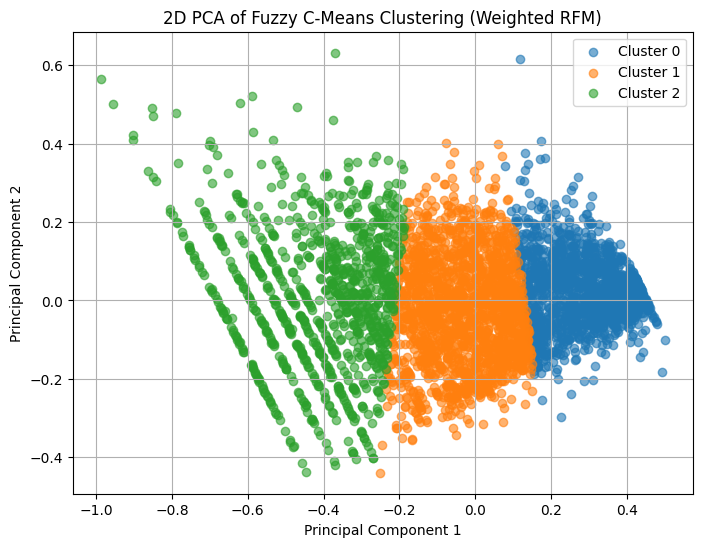

In [ ]:

# STEP 1: Convert InvoiceDate
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d/%m/%Y %H.%M')

# STEP 2: Calculate RFM
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
df['Total'] = df['Quantity'] * df['UnitPrice']

recency = df.groupby('CustomerID')['InvoiceDate'].max().apply(lambda x: (ref_date - x).days)
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()
monetary = df.groupby('CustomerID')['Total'].sum()

rfm = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'Monetary': monetary
})

# STEP 3: Log Transform to reduce skew
rfm['Recency_log'] = np.log1p(rfm['Recency'])
rfm['Frequency_log'] = np.log1p(rfm['Frequency'])
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])

# STEP 4: Apply weights (W in WIVDHFS)
weights = np.array([0.2, 0.3, 0.5])  # Emphasize Recency
rfm_weighted = rfm[['Recency_log', 'Frequency_log', 'Monetary_log']] * weights

# Store weighted versions for plotting
rfm['Recency_weighted'] = rfm['Recency_log'] * weights[0]
rfm['Frequency_weighted'] = rfm['Frequency_log'] * weights[1]
rfm['Monetary_weighted'] = rfm['Monetary_log'] * weights[2]

# STEP 5: Normalize for clustering
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm_weighted)
rfm_scaled_T = rfm_scaled.T

# STEP 6: Fuzzy C-Means Clustering
!pip install -q scikit-fuzzy
import skfuzzy as fuzz

n_clusters = 3
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    rfm_scaled_T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None
)

rfm['Cluster'] = np.argmax(u, axis=0)
rfm['MaxMembershipScore'] = u.max(axis=0)
rfm['Hesitancy'] = 1 - rfm['MaxMembershipScore']
rfm.reset_index(inplace=True)

# STEP 7: Cluster Info
print("Fuzzy Partition Coefficient (FPC):", round(fpc, 4))
print("Cluster Distribution:\n", rfm['Cluster'].value_counts())

# STEP 8: 3D Plot (Plot Weighted RFM Features)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for cluster_id in range(n_clusters):
    cluster_data = rfm[rfm['Cluster'] == cluster_id]
    ax.scatter(
        cluster_data['Recency_weighted'],
        cluster_data['Frequency_weighted'],
        cluster_data['Monetary_weighted'],
        label=f'Cluster {cluster_id}',
        alpha=0.7
    )

ax.set_xlabel('Recency (weighted)')
ax.set_ylabel('Frequency (weighted)')
ax.set_zlabel('Monetary (weighted)')
ax.set_title('Fuzzy C-Means with WIVDHFS-inspired Weighting')
ax.legend()
plt.show()

# STEP 9: PCA 2D Visualization (on weighted space)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8, 6))
for cluster_id in range(n_clusters):
    plt.scatter(
        rfm_pca[rfm['Cluster'] == cluster_id, 0],
        rfm_pca[rfm['Cluster'] == cluster_id, 1],
        label=f'Cluster {cluster_id}',
        alpha=0.6
    )
plt.title("2D PCA of Fuzzy C-Means Clustering (Weighted RFM)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
print("Fuzzy Partition Coefficient (FPC):", round(fpc, 4))


Fuzzy Partition Coefficient (FPC): 0.6423


In [ ]:
# STEP 10: Add additional features needed by RL
import numpy as np

rfm['Season'] = np.random.choice([0, 1, 2, 3], len(rfm))  # 0 = Winter, ..., 3 = Fall
rfm['DaysSinceLastPurchase'] = np.random.randint(1, 90, len(rfm))

# Keep relevant columns
rl_data = rfm[['CustomerID', 'Cluster', 'Hesitancy', 'Season', 'DaysSinceLastPurchase']].copy()

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import random
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env


class CustomerEnv(gym.Env):
    def __init__(self, customer_df):
        super(CustomerEnv, self).__init__()
        self.customers = customer_df.reset_index(drop=True)
        self.n_customers = len(self.customers)

        self.action_space = spaces.Discrete(4)  # 0=Discount, 1=Cross-sell, 2=Wait, 3=Reorder

        # Cluster (0–2), Hesitancy (0–1), Season (0–3), Days (1–90)
        low = np.array([0, 0.0, 0, 1], dtype=np.float32)
        high = np.array([2, 1.0, 3, 90], dtype=np.float32)
        self.observation_space = spaces.Box(low, high, dtype=np.float32)

        self.current_index = 0

    def reset(self, seed=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
        self.current_index = random.randint(0, self.n_customers - 1)
        return self._get_state(), {}

    def _get_state(self):
        row = self.customers.iloc[self.current_index]
        return np.array([
            row['Cluster'],
            row['Hesitancy'],
            row['Season'],
            row['DaysSinceLastPurchase']
        ], dtype=np.float32)

    def step(self, action):
        row = self.customers.iloc[self.current_index]
        revenue = 0
        efficiency = 0

        if action == 0:  # High discount
            revenue = 50 * (1 - row['Hesitancy'])
            efficiency = 0.6
        elif action == 1:  # Cross-sell
            revenue = 30 * (1 - row['Hesitancy'])
            efficiency = 0.8
        elif action == 2:  # Wait
            revenue = 10
            efficiency = 1.0
        elif action == 3:  # Reorder
            revenue = 20
            efficiency = 0.9

        reward = 0.3 * revenue + 0.7 * efficiency * 100
        done = True
        return self._get_state(), reward, done, False, {}

In [ ]:

env = CustomerEnv(rl_data)
check_env(env)
model = DQN(
    "MlpPolicy",
    env,
    gamma=0.99,
    learning_rate=0.003,
    exploration_fraction=0.1,
    train_freq=(4, 'step'),
    verbose=1
)
model.learn(total_timesteps=10000)

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.003    |
|    loss             | 0.872    |
|    n_updates        | 2141     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | 72.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8672     |
|    fps              | 431      |
|    time_elapsed     | 20       |
|    total_timesteps  | 8672     |
| train/              |          |
|    learning_rate    | 0.003    |
|    loss             | 2.05     |
|    n_updates        | 2142     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | 72.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8676     |
|   

In [ ]:
# Evaluate over multiple episodes
rewards = []
action_counts = {0: 0, 1: 0, 2: 0, 3: 0}

for _ in range(1000):
    state, _ = env.reset()
    action, _ = model.predict(state, deterministic=True)
    state, reward, *_ = env.step(action)
    rewards.append(reward)
    action_counts[action.item()] += 1

print("📊 Evaluation Results")
print("Average Reward:", round(np.mean(rewards), 2))
print("Std Dev:", round(np.std(rewards), 2))
print("Action Distribution:", action_counts)

📊 Evaluation Results
Average Reward: 73.0
Std Dev: 0.0
Action Distribution: {0: 0, 1: 0, 2: 1000, 3: 0}


<ipython-input-35-4c7503821750>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Action", y="Reward", estimator=np.mean, errorbar="sd", palette="viridis")


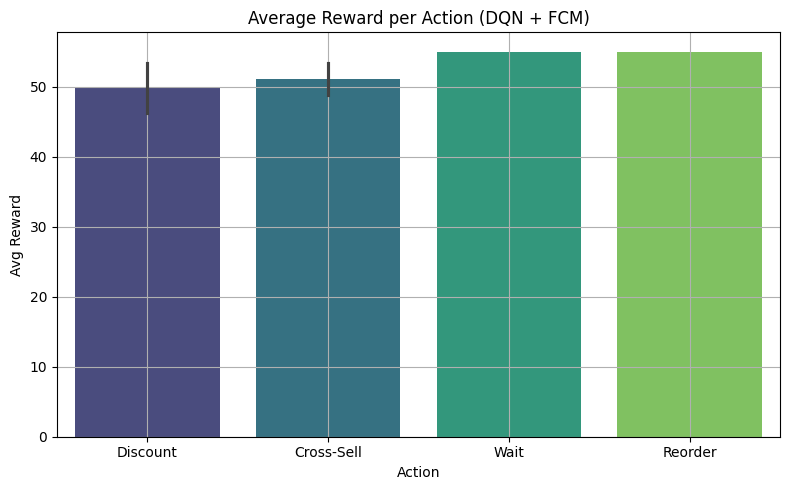

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

results = []
for _ in range(500):
    state, _ = env.reset()
    action, _ = model.predict(state)
    next_state, reward, _, _, _ = env.step(action)
    results.append({
        'Cluster': int(state[0]),
        'Hesitancy': round(float(state[1]), 2),
        'Season': int(state[2]),
        'DaysSinceLastPurchase': int(state[3]),
        'Action': int(action),
        'Reward': reward
    })

df_results = pd.DataFrame(results)

# Reward by action
plt.figure(figsize=(8, 5))
sns.barplot(data=df_results, x="Action", y="Reward", estimator=np.mean, errorbar="sd", palette="viridis")
plt.title("Average Reward per Action (DQN + FCM)")
plt.xlabel("Action")
plt.ylabel("Avg Reward")
plt.xticks([0, 1, 2, 3], ["Discount", "Cross-Sell", "Wait", "Reorder"])
plt.grid(True)
plt.tight_layout()
plt.show()

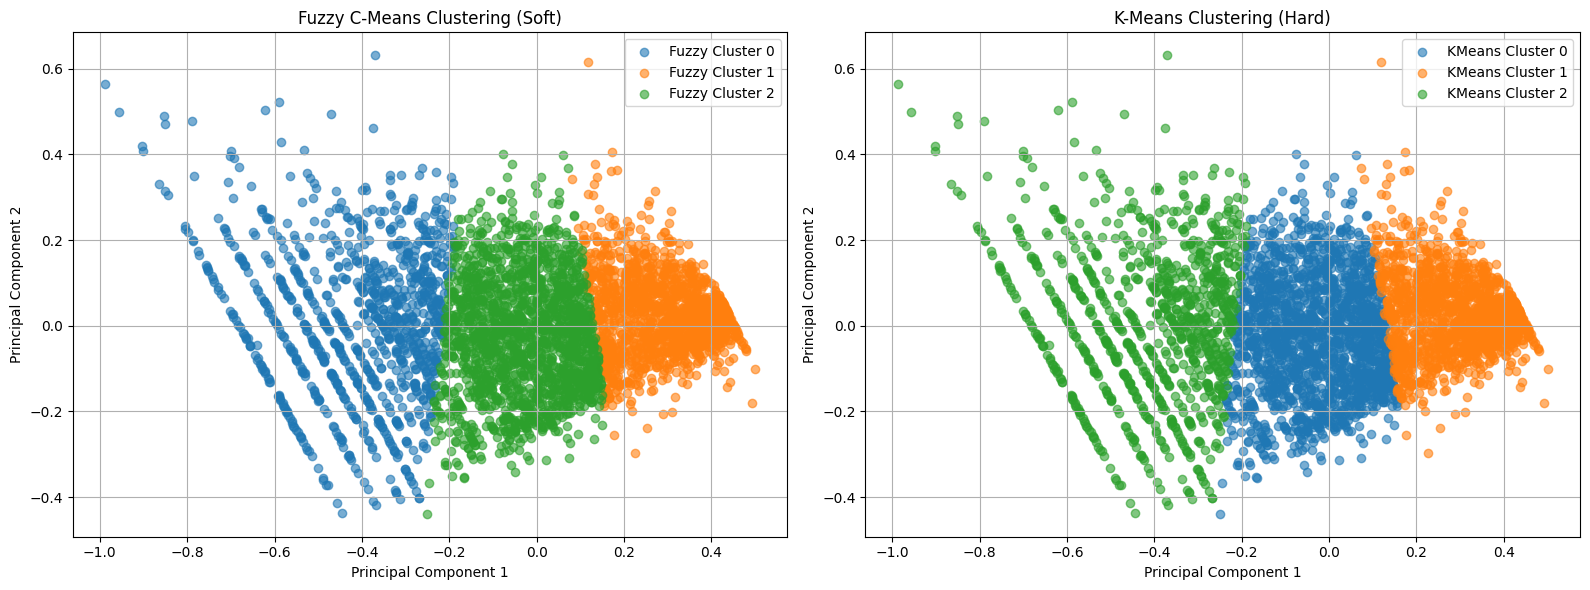

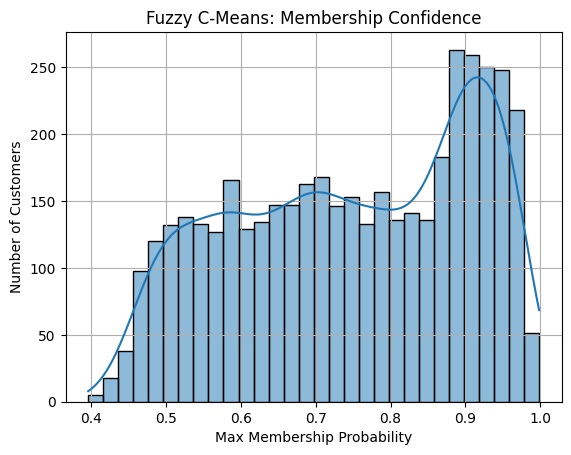

High confidence: 1001
Moderate confidence: 2326
Low confidence: 1010


In [ ]:
# STEP 0: Import KMeans and PCA (for visualization)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# STEP 1: Run KMeans as baseline
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)

# STEP 2: PCA (2D) transformation for easy visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# STEP 3: Side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Fuzzy C-Means Plot
axes[0].set_title("Fuzzy C-Means Clustering (Soft)")
for cluster_id in range(n_clusters):
    axes[0].scatter(
        rfm_pca[rfm['Cluster'] == cluster_id, 0],
        rfm_pca[rfm['Cluster'] == cluster_id, 1],
        label=f'Fuzzy Cluster {cluster_id}',
        alpha=0.6
    )
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")
axes[0].legend()
axes[0].grid(True)

# KMeans Plot
axes[1].set_title("K-Means Clustering (Hard)")
for cluster_id in range(n_clusters):
    axes[1].scatter(
        rfm_pca[rfm['KMeans_Cluster'] == cluster_id, 0],
        rfm_pca[rfm['KMeans_Cluster'] == cluster_id, 1],
        label=f'KMeans Cluster {cluster_id}',
        alpha=0.6
    )
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
import seaborn as sns

# Histogram of Fuzzy Membership Strength
sns.histplot(rfm['MaxMembershipScore'], bins=30, kde=True)
plt.title("Fuzzy C-Means: Membership Confidence")
plt.xlabel("Max Membership Probability")
plt.ylabel("Number of Customers")
plt.grid(True)
plt.show()

# High confidence customers
high_conf = rfm[rfm['MaxMembershipScore'] > 0.9]

# Moderate confidence customers
moderate_conf = rfm[(rfm['MaxMembershipScore'] <= 0.9) & (rfm['MaxMembershipScore'] >= 0.6)]

# Low confidence customers
low_conf = rfm[rfm['MaxMembershipScore'] < 0.6]

# Count for each
print("High confidence:", len(high_conf))
print("Moderate confidence:", len(moderate_conf))
print("Low confidence:", len(low_conf))

#RL

In [ ]:
data = pd.DataFrame({
    'CustomerID': range(1000),
    'Cluster': np.random.choice([0, 1, 2], 1000),
    'Hesitancy': np.random.uniform(0, 1, 1000),
    'Season': np.random.choice([0, 1, 2, 3], 1000),  # e.g., 0=Winter, ..., 3=Fall
    'DaysSinceLastPurchase': np.random.randint(1, 90, 1000)
})

# STEP 3: Custom RL Environment
class CustomerEnv(gym.Env):
    def __init__(self, customer_df):
        super(CustomerEnv, self).__init__()
        self.customers = customer_df.copy().reset_index(drop=True)
        self.n_customers = len(self.customers)

        # Define action space (0: High Discount, 1: Cross-sell, 2: Wait, 3: Restock)
        self.action_space = spaces.Discrete(4)

        # Define state space: Cluster (0–2), Hesitancy (0–1), Season (0–3), Days (1–90)
        low = np.array([0, 0.0, 0, 1], dtype=np.float32)
        high = np.array([2, 1.0, 3, 90], dtype=np.float32)
        self.observation_space = spaces.Box(low, high, dtype=np.float32)

        self.current_index = 0

    def reset(self, seed=None):
        if seed is not None:
          random.seed(seed)
          np.random.seed(seed)

        self.current_index = random.randint(0, self.n_customers - 1)
        return self._get_state(), {}

    def _get_state(self):
        row = self.customers.iloc[self.current_index]
        return np.array([
            row['Cluster'],
            row['Hesitancy'],
            row['Season'],
            row['DaysSinceLastPurchase']
        ], dtype=np.float32)

    def step(self, action):
        # Simulated reward function
        row = self.customers.iloc[self.current_index]

        revenue = 0
        inventory_efficiency = 0

        if action == 0:  # High discount
            revenue = 50 * (1 - row['Hesitancy'])
            inventory_efficiency = 0.6
        elif action == 1:  # Cross-sell
            revenue = 30 * (1 - row['Hesitancy'])
            inventory_efficiency = 0.8
        elif action == 2:  # Wait
            revenue = 10
            inventory_efficiency = 1.0
        elif action == 3:  # Reorder
            revenue = 20
            inventory_efficiency = 0.9

        # Custom reward function: R = w1 * revenue + w2 * efficiency
        w1, w2 = 0.7, 0.3
        reward = w1 * revenue + w2 * inventory_efficiency * 100

        done = True
        truncated = False
        info = {}

        return self._get_state(), reward, done, truncated, info

# STEP 4: Initialize environment
env = CustomerEnv(data)
check_env(env)  # check compatibility

# STEP 5: Train DQN agent
model = DQN("MlpPolicy", env, verbose=1, learning_rate=0.001, tensorboard_log="./dqn_marketing_log/")
model.learn(total_timesteps=10000)

# STEP 6: Run simulation (with Gym 0.26+ fix)
state, _ = env.reset()  # Unpack the observation from reset() tuple
for _ in range(10):
    action, _states = model.predict(state)
    state, reward, done, _, _ = env.step(action)
    print(f"Action: {action}, Reward: {reward:.2f}, New State: {state}")
    state, _ = env.reset()  # Reset again for the next simulation round







Streaming output truncated to the last 5000 lines.
| time/               |          |
|    episodes         | 8672     |
|    fps              | 384      |
|    time_elapsed     | 22       |
|    total_timesteps  | 8672     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.31     |
|    n_updates        | 2142     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | 40.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8676     |
|    fps              | 384      |
|    time_elapsed     | 22       |
|    total_timesteps  | 8676     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.11     |
|    n_updates        | 2143     |
----------------------------------
----------------------------------
| rollout/            |          |
|   

# Evaluation

In [ ]:
# Sample pre-clustered customer dataset (simulate input)
data = pd.DataFrame({
    'CustomerID': range(1000),
    'Cluster': np.random.choice([0, 1, 2], 1000),
    'Hesitancy': np.random.uniform(0, 1, 1000),
    'Season': np.random.choice([0, 1, 2, 3], 1000),  # e.g., 0=Winter, ..., 3=Fall
    'DaysSinceLastPurchase': np.random.randint(1, 90, 1000)
})


📊 Evaluation Results
Average Reward over 10000 episodes: 41.00
Standard Deviation: 0.00
Action Distribution: {0: 0, 1: 0, 2: 0, 3: 10000}


<ipython-input-9-92bb6dd3cc98>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-9-92bb6dd3cc98>:52: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


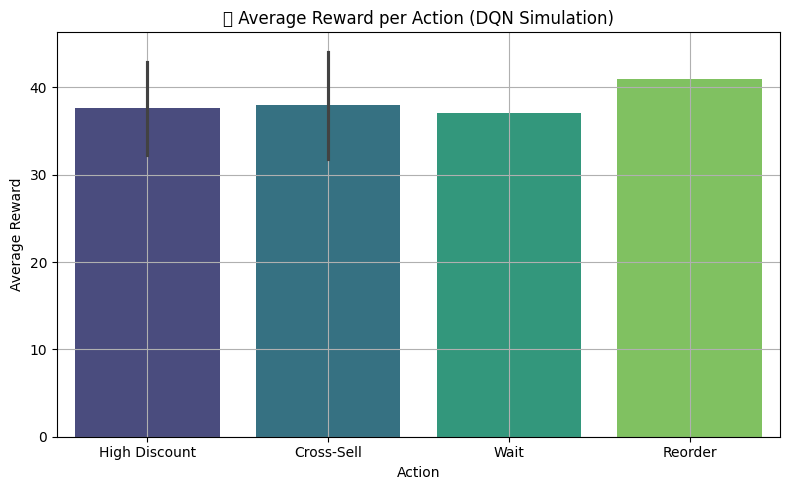

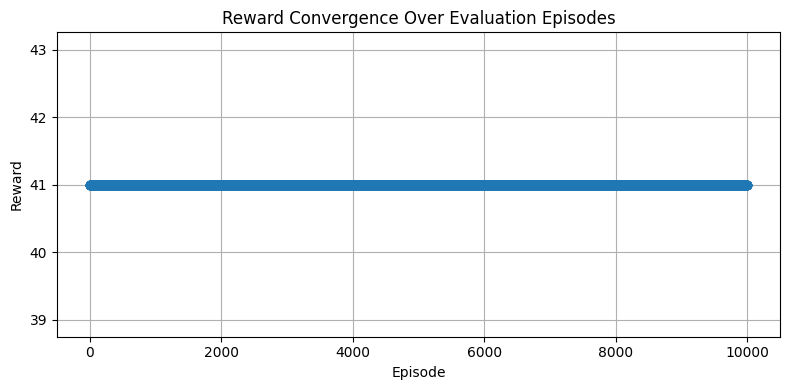

In [ ]:
# STEP 6: Evaluate agent decision performance
n_eval_episodes = 10000
rewards = []
action_counts = {0: 0, 1: 0, 2: 0, 3: 0}

for _ in range(n_eval_episodes):
    state, _ = env.reset()
    action, _ = model.predict(state, deterministic=True)
    state, reward, done, truncated, _ = env.step(action)
    rewards.append(reward)
    action_counts[action.item()] += 1

print("\n📊 Evaluation Results")
print(f"Average Reward over {n_eval_episodes} episodes: {np.mean(rewards):.2f}")
print(f"Standard Deviation: {np.std(rewards):.2f}")
print("Action Distribution:", action_counts)

# STEP 7: Plot Reward vs Action heatmap
results = []
for _ in range(500):
    state, _ = env.reset()
    action, _ = model.predict(state)
    next_state, reward, _, _, _ = env.step(action)
    results.append({
        'Cluster': int(state[0]),
        'Hesitancy': round(float(state[1]), 2),
        'Season': int(state[2]),
        'DaysSinceLastPurchase': int(state[3]),
        'Action': int(action),
        'Reward': reward
    })

df_results = pd.DataFrame(results)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_results,
    x="Action",
    y="Reward",
    estimator=np.mean,
    errorbar='sd',
    palette="viridis"
)
plt.title("\U0001F4CA Average Reward per Action (DQN Simulation)")
plt.xlabel("Action")
plt.ylabel("Average Reward")
plt.xticks(
    ticks=[0, 1, 2, 3],
    labels=["High Discount", "Cross-Sell", "Wait", "Reorder"]
)
plt.grid(True)
plt.tight_layout()
plt.show()

# STEP 8: Reward Convergence Curve
plt.figure(figsize=(8, 4))
plt.plot(rewards, marker='o', alpha=0.6)
plt.title("Reward Convergence Over Evaluation Episodes")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.tight_layout()
plt.show()
